In [412]:
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [413]:
# Loading data and check if it's loaded properly
df = pd.read_csv("Paitients_Files_Train.csv", delimiter=",")
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [414]:
# drop 2 irrelevant columns: ID and Insurance
df.drop(columns="ID", inplace=True)
df.drop(columns="Insurance", inplace=True)

In [415]:
# rename the column so that it's easier to evaluate them later
df = df.rename(columns={
    "PRG": "BGlucose",
    "PR": "BPressure",
    "PL": "B1",
    "SK": "B2",
    "TS": "B3",
    "BD2": "B4",
    "M11": "BMI"
})

# EDA

In [416]:
# Inspect data types of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BGlucose   599 non-null    int64  
 1   B1         599 non-null    int64  
 2   BPressure  599 non-null    int64  
 3   B2         599 non-null    int64  
 4   B3         599 non-null    int64  
 5   BMI        599 non-null    float64
 6   B4         599 non-null    float64
 7   Age        599 non-null    int64  
 8   Sepssis    599 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 42.2+ KB


In [417]:
pd.isna(df).sum()

BGlucose     0
B1           0
BPressure    0
B2           0
B3           0
BMI          0
B4           0
Age          0
Sepssis      0
dtype: int64

In [418]:
df.describe()

,BGlucose,B1,BPressure,B2,B3,BMI,B4,Age
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


# Preprocessing

## Spliting depedent and independent variables

In [419]:
X = df.drop(columns="Sepssis")
X = X.reset_index(drop=True)

Y = df[['Sepssis']]

print(X.shape)
print(Y.shape)

(599, 8)
(599, 1)


In [420]:
# Encode target value

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y.values.ravel())


print(Y[:5])

[1 0 1 0 1]


## Outliers

In [421]:
import numpy as np
for col in X.columns:
    percentiles = X[col].quantile([0.01, 0.99]).values
    X[col] = np.clip(X[col], percentiles[0], percentiles[1])

In [422]:
from imblearn.over_sampling import SMOTE, SVMSMOTE
over = SMOTE(sampling_strategy="minority",random_state=3)
X_over, Y_over = over.fit_resample(X,Y)


# Models Development

**Miscelleous codes**

In [321]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.pipeline import Pipeline as ImPipeline

In [342]:
def draw_confusion_matrix(cnf_matrix):
    class_names=["Positive","Negative"] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [323]:
def print_evaluate_score(y_test, y_pred):
    cnf = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    draw_confusion_matrix(cnf)

In [431]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

from sklearn import model_selection
def print_cross_validate(model):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

    results = model_selection.cross_validate(estimator=model,
                                            X=X,
                                            y=Y,
                                            cv=kfold,
                                            scoring=scoring, return_train_score=False)
                                            
    print("F1-score: %.3f"%results["test_f1_score"].mean())
    print("Accuracy score: %.3f"%results["test_accuracy"].mean())
    print("Recall score: %.3f"%results["test_recall"].mean())

In [324]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,f1_score, classification_report

def get_best_model(model, trainX, trainY):

    fold_number = 5
    fold_repeat = 10
    kf = RepeatedKFold(n_splits=fold_number, n_repeats=fold_repeat, random_state=4)

    best_f1 = 0.0
    s = 0
    best_pred = None
    best_y_test = None

    for train_index, test_index in kf.split(trainX):
        X_train, X_test = trainX.iloc[train_index], trainX.iloc[test_index]
        y_train, y_test = trainY[train_index], trainY[test_index]

        model.fit(X_train,y_train)
        pred = model.predict(X_test)

        f1_sc = f1_score(y_test, pred)
        if f1_sc > best_f1:
            best_f1 = f1_sc
            best_pred = pred
            best_y_test = y_test
    print_evaluate_score(best_y_test, best_pred)


## 1. Logistic Regression

In [325]:
# use polynomial to improve model fitting
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1)

# instantiate the model (using the default parameters)
solver = "liblinear"
lr_model = LogisticRegression(C=1, solver= solver, 
max_iter=7000, tol=0.01,
penalty="l1", random_state=4)

scaler = RobustScaler()

lr_pipe = ImPipeline(steps=[("poly",poly),
                            ("scaler",scaler),
                            ("logistic",lr_model)])

In [343]:
# SearchGrid CV
from sklearn.model_selection import GridSearchCV
param_grid = {
    "logistic__C":np.logspace(-1, 2, 10),
    "logistic__class_weight": ["balanced"],
    "logistic__penalty":["l1","l2"],
    "poly__degree":[1,2,3,4]

}
search = GridSearchCV(lr_pipe, param_grid, scoring="f1",cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=4))
search.fit(X_over, Y_over)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.760):
{'logistic__C': 4.6415888336127775, 'logistic__class_weight': 'balanced', 'logistic__penalty': 'l1', 'poly__degree': 3}


In [344]:
logistic__C = search.best_params_["logistic__C"]
logistic__class_weight = search.best_params_["logistic__class_weight"]
logistic__penalty = search.best_params_["logistic__penalty"]
poly_degree = search.best_params_["poly__degree"]
best_logisticReg = LogisticRegression(
    penalty= logistic__penalty,
    C= logistic__C,
    class_weight=logistic__class_weight,
    random_state=4,
    solver= solver,
    max_iter=7000
)
poly = PolynomialFeatures(degree=poly_degree)

print(best_logisticReg)

LogisticRegression(C=4.6415888336127775, class_weight='balanced', max_iter=7000,
                   penalty='l1', random_state=4, solver='liblinear')


In [345]:
best_logistic_pipe = Pipeline(steps=[("poly",poly),("scaler", scaler), ("model",best_logisticReg)])

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        74
           1       0.71      0.76      0.74        46

    accuracy                           0.79       120
   macro avg       0.78      0.79      0.78       120
weighted avg       0.79      0.79      0.79       120



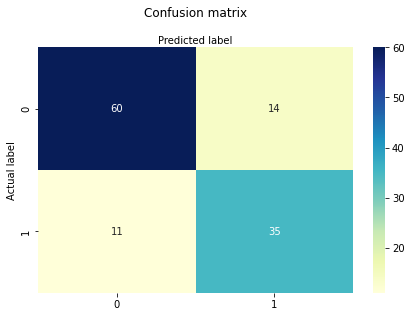

In [346]:
best_logisticReg = get_best_model(best_logistic_pipe, X, Y)

In [432]:
print_cross_validate(best_logistic_pipe)


F1-score: 0.631
Accuracy score: 0.727
Recall score: 0.671


## 2. Ridge Regression

## 3. Decision Tree

In [423]:
df["Sepssis"] = np.where(df["Sepssis"].str.contains("Positive"), 1, 0)


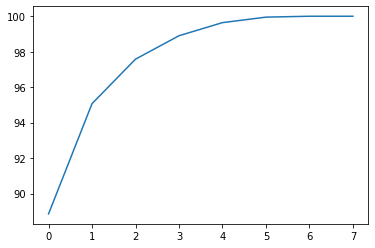

In [424]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(df)
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

plt.plot(var1)

In [442]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline

from sklearn.decomposition import PCA
pca = PCA(n_components=5)

# under = NeighbourhoodCleaningRule(n_neighbors=4, threshold_cleaning=0.5)
# under = RandomUnderSampler(random_state=1)

dtree_model = DecisionTreeClassifier(max_features="sqrt", random_state=4, ccp_alpha=0.0032)
steps = [('pca', pca),('model', dtree_model)]
dtree_pipe = Pipeline(steps=steps)

In [443]:
param_grid = {
    "model__class_weight": [{0:0.4,1:0.6}, {0:0.42,1:0.58},{0:0.45,1:0.55},{0:0.5,1:0.5}],
    "model__ccp_alpha": np.logspace(-3,1,10),
    "model__max_depth": [2,3,4],
    "model__min_samples_leaf": [1,2,3,4,5],

}
cv = RepeatedKFold(n_splits=5, n_repeats=8, random_state=4)
search = GridSearchCV(dtree_pipe, param_grid, scoring="f1",cv=10, error_score="raise")
search.fit(X_over, Y_over)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.741):
{'model__ccp_alpha': 0.0027825594022071257, 'model__class_weight': {0: 0.45, 1: 0.55}, 'model__max_depth': 4, 'model__min_samples_leaf': 5}


In [444]:
b_params = search.best_params_
model__class_weight = b_params["model__class_weight"]
model__ccp_alpha = b_params["model__ccp_alpha"]
model__max_depth = b_params["model__max_depth"]
model__min_samples_leaf = b_params["model__min_samples_leaf"]

dtree_model = DecisionTreeClassifier(max_features="sqrt",
class_weight=model__class_weight, 
random_state=4, 
ccp_alpha=model__ccp_alpha,
max_depth=model__max_depth,
min_samples_leaf=model__min_samples_leaf)

steps = [('pca', pca), ('model', dtree_model)]

dtree_pipe = Pipeline(steps=steps)


              precision    recall  f1-score   support

           0       0.83      0.79      0.81        75
           1       0.67      0.73      0.70        45

    accuracy                           0.77       120
   macro avg       0.75      0.76      0.76       120
weighted avg       0.77      0.77      0.77       120



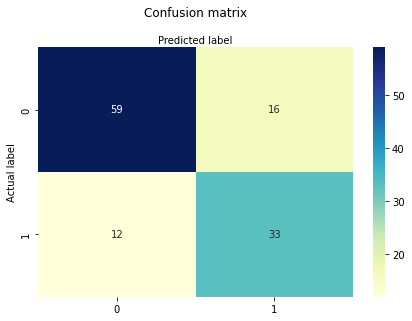

In [445]:
get_best_model(dtree_pipe, X, Y)

In [446]:
print_cross_validate(dtree_pipe)

F1-score: 0.586
Accuracy score: 0.710
Recall score: 0.601


## 4. Random Forest

## 5. Boosting


              precision    recall  f1-score   support

           0       0.79      0.85      0.82        66
           1       0.88      0.83      0.86        90

    accuracy                           0.84       156
   macro avg       0.84      0.84      0.84       156
weighted avg       0.84      0.84      0.84       156



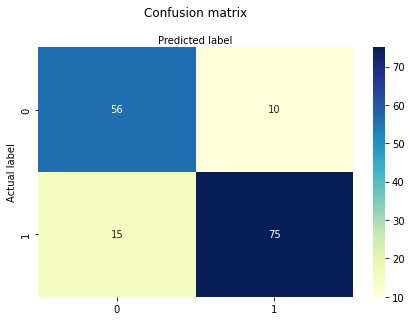

In [454]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=250, learning_rate=0.8, max_depth=1, random_state=0).fit(X_over, Y_over)
get_best_model(clf, X_over, Y_over)

In [455]:
print_cross_validate(clf)

F1-score: 0.596
Accuracy score: 0.735
Recall score: 0.567
